### model brand

In [8]:
import pandas as pd
import re

In [9]:
def load_df_products(name):
    return pd.read_csv(f'../data/processed/data_beer_{name}.csv')

In [10]:
data_beer = load_df_products('total')

In [11]:
data_beer.head()

,price,price_liter,title,promotion,brand,container,volumen_unid,quantity_pack,image_url,supermarket,id
0,11.21,1.89,Cerveza Heineken Lager pack de 18 latas de 33 cl.,No promotion,heineken lager,lata,33 cl,18,https://static.carrefour.es/hd_280x_/img_pim_f...,Carrefour,0
1,14.80,1.60,Cerveza Cruzcampo Pilsen pack de 28 latas de 3...,No promotion,cruzcampo pilsen,lata,33 cl,28,https://static.carrefour.es/hd_280x_/img_pim_f...,Carrefour,1
2,5.15,1.56,Cerveza El Aguila pack de 10 latas de 33 cl.,No promotion,el aguila,lata,33 cl,10,https://static.carrefour.es/hd_280x_/img_pim_f...,Carrefour,2
3,0.25,0.76,Cerveza Carrefour Holandesa lata 33 cl.,No promotion,carrefour holandesa,lata,33 cl,1,https://static.carrefour.es/hd_280x_/img_pim_f...,Carrefour,3
4,14.15,1.53,Cerveza Mahou Clásica pack de 28 latas de 33 cl.,No promotion,mahou clásica,lata,33 cl,28,https://static.carrefour.es/hd_280x_/img_pim_f...,Carrefour,4


In [12]:
def change_brand(brand_raw):
    names_brands = '''ramblers|amstel|mahou|dia|heineken|san miguel|estrella galicia|voll-damm|1906|budweiser|
    |cruzcampo|buckler|dia shandy|desperado|grimbergen|franziskaner|paulaner|corona|guinness|el aguila|
    |ambar|alhambra|coronita|leffe|kronenbourg|carlsberg|la salve|warsteiner|mexicana|pacífico|guiness|
    |founders|spatem|beck|cubanisto|aurum|keler|woll-damm|aurum|ambar|free damm|ladrón de manzanas|
    |brewdog|ipa lagunitas|inedit|daura|oro|estrella damm|damm|complot|corgon gard|judas|olañeta|
    |grevensteiner|inedit|chimay|house 13|lorea ipa boga|trappe|mort subite|kirin|urquell|cruz campo|
    |malquerida|moretti|clausthaler|affligem|stella artoi|sol|quilmes|daura marzen|turia|boga|
    |schöfferhofer|grolsch|la goudale|atkien dunkel|chérie|belzebuth|la virgen|lowenbrau|bulmers|jai alai|
    |strongbow|cruz del sur|voll damm|estrella levante|xibeca|victoria|estrella del sur|aliada|moritz|
    |brabante|superbock|kirin ichiban|staropramen|waterloo|weltenburger|schwaben|dab|praga|abbot|
    |lowenbräu|spaten|hofbräu|dos equis|birra moretti|karmeliet|kwak|gordon|martin's|delirium tremens|veltins|
    |pacifico|triple secret des moine|la bière du demon|baltika|molino viejo|cusqueña|cobra|zywiec|barista|
    |bischofshof|hoegaarden|schofferhofer|erdinger|konig ludwig|casimiro mahou|rosita|burro de sancho|
    |monkey|arriaca|ladron de manzanas|kopparberg|la sagra|sierra nevada|montseny|maisel & friends|
    |tyris|rabiosa|jaira|forastera|cibeles|mulhacen|gredos|ballut|madri chulapo|gastheiz|quijota|
    |marijuana|moli balear|dolina|icue|bizantina|bavaria|newcastle|timmermans|modelo|heifer|holbrand|
    |rubai|el águila|estrella de galicia|chouffe|peroni|miller|goya|super bock|sam miguel|karamalz|
    |skol|budejovicky|wersteiner|duvel|schneider weisse|john smith's|blue moon|rochefort-8|salitos|
    |old empire|köning ludwing weissbier|könig ludwig weissbier|blanche de charleroi|ruddles|
    |madrí chulapo|abbaye d'aulne|g de goudale|cuzqueña|london pride|wychwood hobgoblin|sureña|
    |innis&gunn|intense gold|faxe|bitburger|lindemans|maisel&friends|pearl jet|the one|original intense|
    |licher|tennent's|tedeum|enigma|mulhacén|gervensteiner|abbaye du lys|greventeiner|liefmans|rubia 4|
    |san sebastian|maisel|carrefour|koenigsbier|polar|coors|kadabra|brooklyn|alsfelder|madriz|presidente|
    |fentiman's de jengibre|lammsbräu|riedenburger|benediktinerabtei|iron maiden|old speckled hen|
    |ordio minero|rubia dab|corte ingles|thatchers gold'''
  
    brand = re.findall(names_brands,brand_raw)
    if len(brand)>1:
        for name in brand:
            if len(name)>3:
                return name
    else:
        return brand[0]

In [13]:
data_beer['brand'].apply(change_brand)

0        heineken
1       cruzcampo
2       el aguila
3       carrefour
4           mahou
          ...    
1561    cruzcampo
1562    la virgen
1563        ambar
1564    lowenbrau
1565     brooklyn
Name: brand, Length: 1566, dtype: object

In [14]:
data_beer['brand'] = data_beer['brand'].apply(change_brand)

In [15]:
def duplicate_brand_error(data):
    if data == 'guiness':
        return 'guinness'
    elif data == 'cruz campo':
        return 'cruzcampo'
    elif data == 'voll damm':
        return 'voll-damm'
    elif data == 'schofferhofer':
        return 'schöfferhofer'
    elif data == 'ladron de manzanas':
        return 'ladrón de manzanas'
    elif data == 'el aguila':
        return 'el águila'
    elif data == 'estrella de galicia':
        return 'estrella galicia'
    elif data == 'superbock':
        return 'super bock'
    elif data == 'sam miguel':
        return 'san miguel'
    elif data == 'madri chulapo':
        return 'madrí chulapo'
    elif data == ('maisel' or 'maisel&friends'):
        return 'maisel & friends'
    elif data == 'köning ludwing weissbier':
        return 'könig ludwig weissbier'
    else:
        return data

In [16]:
data_beer['brand'] = data_beer['brand'].apply(duplicate_brand_error)

In [17]:
data_beer['brand'].value_counts()

mahou                 151
san miguel            120
amstel                 87
cruzcampo              80
ambar                  71
                     ... 
corte ingles            1
la bière du demon       1
wychwood hobgoblin      1
iron maiden             1
benediktinerabtei       1
Name: brand, Length: 212, dtype: int64

In [18]:
data_beer_images= pd.DataFrame(columns=['id','local','brand'])

In [19]:
data_beer_images['id'] = data_beer['id']
data_beer_images['id'] = data_beer_images['id'].map(str)

In [20]:
data_beer_images['brand'] = data_beer['brand']

In [21]:
def local_beer(local):
    return f'/home/ivan/Documentos/IRONHACK/Bootcamp/final_project/Birras_Pipol_House/beer_images/{local}.jpg'

In [22]:
data_beer_images['local'] = data_beer_images['id'].apply(local_beer)

In [23]:
data_beer_images = data_beer_images[['local','brand']]

In [25]:
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np

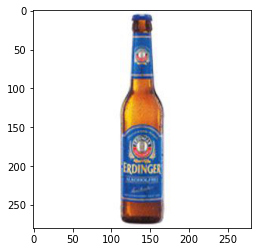

In [27]:
I = Image.open("../beer_images/505.jpg")
plt.imshow(np.asarray(I))
plt.show()


In [28]:
print(I.size, I.format)

(280, 280) JPEG


In [29]:
from sklearn.model_selection import train_test_split
beer_train, beer_test = train_test_split(data_beer_images)

In [30]:
beer_test

,local,brand
312,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,g de goudale
71,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,alhambra
641,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,könig ludwig weissbier
91,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,amstel
72,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,free damm
...,...,...
1192,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,buckler
459,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,cruzcampo
322,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,benediktinerabtei
963,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,stella artoi


In [31]:
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [32]:
data_gen = ImageDataGenerator(rescale=1/255)

X_train = data_gen.flow_from_dataframe(dataframe=beer_train,
                                        x_col='local', y_col='brand',
                                        subset='training',
                                        class_mode='categorical')

X_validation = data_gen.flow_from_dataframe(dataframe=beer_test,
                                            x_col='local', y_col='brand',
                                            subset='validation',
                                            class_mode='categorical')

Found 1174 validated image filenames belonging to 188 classes.
Found 0 validated image filenames belonging to 120 classes.


In [33]:
model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer = 'Adam',metrics=['accuracy'])

In [34]:
train_steps = X_train.n//X_train.batch_size
# validation_steps = X_validation.n//X_validation.batch_size

history = model.fit(X_train,steps_per_epoch=train_steps, epochs=20)
#                               validation_data=X_validation,validation_steps=validation_steps)

Epoch 1/20


InvalidArgumentError:  Incompatible shapes: [128,1] vs. [32,188]
	 [[node gradient_tape/binary_crossentropy/logistic_loss/mul/BroadcastGradientArgs (defined at <ipython-input-34-07e540b79224>:4) ]] [Op:__inference_train_function_1031]

Function call stack:
train_function
